In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## dataset link - https://www.kaggle.com/competitions/quora-question-pairs/data

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/similar-sentences/train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
data.shape

(404290, 6)

In [4]:
data.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [5]:
data = data.dropna()
data.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [6]:
data.shape

(404287, 6)

In [7]:
data.duplicated().sum()

np.int64(0)

In [8]:
print(data['is_duplicate'].value_counts())
print((data['is_duplicate'].value_counts() / data['is_duplicate'].count())*100)

is_duplicate
0    255024
1    149263
Name: count, dtype: int64
is_duplicate
0    63.079941
1    36.920059
Name: count, dtype: float64


In [9]:
dd = pd.concat([data['question1'], data['question2']], ignore_index=True)
print(dd.nunique())
print(dd.value_counts()[dd.value_counts() > 1].shape[0])

dd.head()

537359
111870


,0
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


In [10]:
dd.shape

(808574,)

<Axes: >

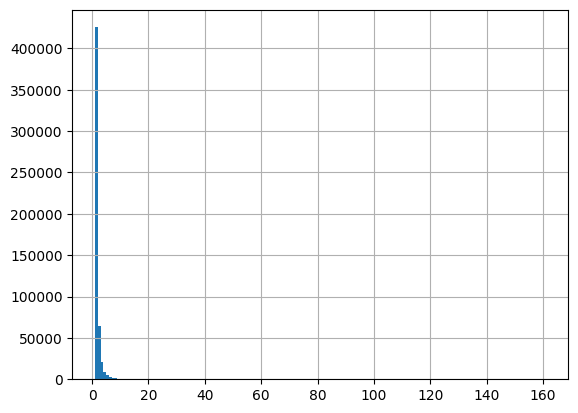

In [11]:
dd.value_counts().hist(bins=160)

In [12]:
dd.value_counts().max()

161

In [ ]:
!pip3 install sentence-transformers

In [14]:
### This process, when CPU is used for calculation

# from sentence_transformers import SentenceTransformer, util

# data['is_similar'] = 0

# for start in range(0, len(data), 10000):
#     end = min(start + 10000, len(data))
#     batch = data.iloc[start:end]

#     embeddings1 = model.encode(batch['question1'].tolist(), convert_to_tensor=True, show_progress_bar=False)
#     embeddings2 = model.encode(batch['question2'].tolist(), convert_to_tensor=True, show_progress_bar=False)

#     similarities = util.cos_sim(embeddings1, embeddings2).diagonal().cpu().numpy()

#     data.loc[start:end-1, 'is_similar'] = (similarities >= 0.8).astype(int)

# data['is_similar'].value_counts()

In [ ]:
## This process, when GPU is used for calculation

from sentence_transformers import SentenceTransformer, util
import torch

# model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

def compute_similarity_batched(df, batch_size=1000):
    df['is_similar'] = 0

    for start in range(0, len(df), batch_size):
        end = min(start + batch_size, len(df))
        batch = df.iloc[start:end]

        embeddings1 = model.encode(batch['question1'].tolist(), convert_to_tensor=True, show_progress_bar=True)
        embeddings2 = model.encode(batch['question2'].tolist(), convert_to_tensor=True, show_progress_bar=True)

        similarities = util.cos_sim(embeddings1, embeddings2).diagonal().cpu().numpy()

        # df.iloc[start:start + len(similarities), df.columns.get_loc('is_similar')] = (similarities >= 0.8).astype(int)
        df.iloc[start:end, df.columns.get_loc('is_similar')] = (similarities >= 0.8).astype(int)

        torch.cuda.empty_cache()

    return df

batch_size = 1000
data = compute_similarity_batched(data, batch_size)

print(data['is_similar'].value_counts())

In [16]:
match_df = pd.DataFrame(data['is_similar'] == data['is_duplicate'], columns=['match'])
match_df['match'].value_counts()

,count
match,
True,326871
False,77416


In [17]:
print("accuracy: ", (match_df['match'].value_counts()[0] / match_df['match'].count())*100)

accuracy:  80.85122697489655


<ipython-input-17-398802d9cc15>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("accuracy: ", (match_df['match'].value_counts()[0] / match_df['match'].count())*100)
